D:\OneDrive - Cardiff University\05 - Python\06 - PhD
D:
OneDrive - Cardiff University
05 - Python
06 - PhD
D:\


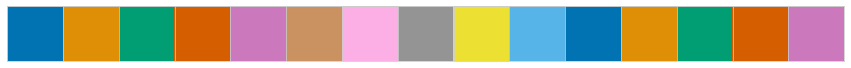

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import calendar
from pandas.tseries import offsets
from datetime import date
from datetime import datetime
import matplotlib.ticker as tkr
import math
import sys
import os

%matplotlib inline  

season_dict = {"Winter":1, "Spring":2, "Summer":3, 'High Summer':4, "Autumn":5}

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
fig_format = "png"
dpi = 600
figsize = (12, 6.5)
figsize_map = (3, 3)
sns.palplot(sns.color_palette())

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)

sys.path.append(computer_path + r"OneDrive - Cardiff University/05 - Python/01 - Packages/Features")

import normality_test as normality
import feature_selection
import clustering
import post_processing
import machine_learning_functions


# uk_hol= holidays.UK() #load UK holiday

In [97]:
path=computer_path+ r"OneDrive - Cardiff University/04 - Projects/10 - Papers and conferences/02 - ECOS conference/Heat-pumps data/csv/"
path_save=computer_path+r"OneDrive - Cardiff University/04 - Projects/10 - Papers and conferences/02 - ECOS conference/02 - Analysis/01 - Results/"

In [98]:
def prepareData(data):
    data["Date"]= data["Year"].map(str)+"/"+data["Month"].map(str)+"/"+data["Day"].map(str)
    data["Date"] = pd.to_datetime(data["Date"]+ " "+data["Hour"].map(str)+":"+ data["Minute"].map(str) , format="%Y%m%d %H:%M")
    data.drop(["Matlab_time"], axis=1, inplace=True)
    data.sort_values("Date", inplace=True)
    data.set_index("Date", inplace=True)

    
def ExtractAndMerge(path):
    frames = []

    for fn in os.listdir(path):
        print(fn)
        print(fn)
        if os.path.splitext(fn)[1]==".csv":
            data = pd.read_csv(path+fn)
            frames.append(data)

    result = pd.concat(frames,axis=0)
    return result


def ExtractAndMergeHP(path):
    frames = []
    count=0
    for fn in os.listdir(path):
        if count<600:
            if os.path.splitext(fn)[1]==".csv":

                data = pd.read_csv(path+fn)
                ref=os.path.splitext(fn)[0].split('_')[1]
        #             print(data.shape)
                prepareData(data)
                    # # Convert to kW
                data.dropna(how="any", subset=["Ehp"], inplace=True)
                max_COP = 5
                min_COP = 0
                data["COP"] = data["Hhp"]/data["Ehp"]
                data.loc[data["COP"]<=min_COP, :]=np.nan
                data.loc[data["COP"]>=max_COP, :]=np.nan
                data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost", "Hhp", "COP"]]=data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost", "Hhp", "COP"]]*30/1000
                data=data.loc[:, ["Ehp", "Edhw", "Esp", "Eboost", "Hhp", "COP"]].resample('30min').mean()
                find_fill_outliers(data, "Ehp", True, True)
                find_fill_outliers(data, "COP", True, True)
                data["Ehp"]= normalize_serie(data["Ehp"])
                data["Hhp"]= normalize_serie(data["Hhp"])

                data["Ref"]=ref.upper()
                frames.append(data)
                count=count+1

    result = pd.concat(frames,axis=0)
    return result

def normalize_serie(x):
    z = (x-x.min())/(x.max()-x.min())
    return z

def addTimePeriod(data):
    data["Hour"] = data.index.hour
    data["DayOfWeek_name"]= [calendar.day_name[x] for x in data.index.dayofweek]
    data["DayOfWeek"]= data.index.dayofweek
    data["Day"]= data.index.dayofyear
    data["Month"] =data.index.month
    data["Year"] =data.index.year
    data["Month name"] = [calendar.month_name[x] for x in data["Month"]]
    data["Weekday"] = [1 if x<5 else 0 for x in data.index.dayofweek]
    data["HH"] = [x%48 for x in range(0, data.shape[0], 1) ]
    data["Date"] = data.index.date
    data["Week"] = data.index.week

    inv_season_dict = {v: k for k, v in season_dict.items()}
    data['Season'] = data.apply(get_season, axis=1)
    data['Season num'] = data['Season']
    data.replace({"Season num":season_dict}, inplace=True)

def get_season(row):
    if row['Month'] >= 4 and row['Month'] <= 5: #April and May
        return 'Spring'
    elif row['Month'] >= 6 and row['Month'] <= 6: # June
        return 'Summer'
    elif row['Month'] >= 7 and row['Month'] <= 8: # July and August
        return 'High Summer'
    elif row['Month'] >= 9 and row['Month'] <= 10: # September and October
        return 'Autumn'
    else:
        return 'Winter'
    
    
def find_fill_outliers(df, serie_name, rolling, fillna):
    #4 sigma rules and 6 hours window
    df[serie_name +" zscore"]=0
    if rolling:
        df[serie_name +" zscore"]= rolling_zscore(df[serie_name], 12)
        df[serie_name +" zscore"].fillna(zscore(df[serie_name]), inplace=True)
    else:
        df[serie_name +" zscore"]=zscore(df[serie_name])
    df.loc[abs(df[serie_name+" zscore"])>4, serie_name]=np.nan
    df.drop(serie_name +" zscore", axis=1, inplace=True)
    if fillna:
        df[serie_name].fillna(df[serie_name].rolling(window=6, center=True, min_periods=3).mean(), inplace=True)
        df[serie_name].interpolate(inplace=True)
    
def zscore(x):
    z=(x-x.mean())/x.std()
    return z
    
def rolling_zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [99]:
def display_clusters(df, nb_clusters, cluster_centers, file_name):
    color=sns.color_palette("Set2", 10)
    fig, ax = plt.subplots(figsize=(28, 10))
    idx = pd.IndexSlice
    x=[val for val in range(0, df.shape[1],1)]
    for n_cluster in range(nb_clusters):
        nb_item= df.index.get_level_values(1).value_counts()[n_cluster]
        if nb_item>1:
#             df.loc[idx[:, n_cluster], :].T.plot(ax=ax, c=color[n_cluster], alpha=0.8, linewidth=0.5)
            y1 = df.loc[idx[:, n_cluster], :].quantile(0.05, axis=0).values
            y2 = df.loc[idx[:, n_cluster], :].quantile(0.95, axis=0).values
            ax.fill_between(x, y1, y2, color=color[n_cluster], alpha=0.5)
            plt.plot(x, cluster_centers[n_cluster], color=color[n_cluster], alpha=1, label="cluster "+str(n_cluster+1)+" Obs:"+str(nb_item))

#     ax.legend_.remove()
#     ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlabel("Time [h]", fontsize=24)
    ax.set_ylabel("Energy content per hour [kWh]", fontsize=24)
    lines, labels = ax.get_legend_handles_labels()
    new_lines =[]
    new_labels =[]
    for x in range(len(labels)):
        if "cluster" in labels[x]:
            new_labels.append(labels[x])
            new_lines.append(lines[x])

    lgd = ax.legend(new_lines, new_labels,prop={'size':24}, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.margins(0,None)
#     plt.savefig(path+ "cluster " +file_name+"."+fig_format, bbox_inches='tight',format=fig_format, dpi=1000) 
    plt.show()
    plt.close(fig)
    return y1, y2

In [100]:
from sklearn.cluster import KMeans
from sklearn import metrics

def cluster(values, max_cluster):
    algorithm = "elkan"
    min_silhouette_avg = 0.
    cluster_centers=[]
    cluster_labels=[]
    for n_clusters in range(2, max_cluster, 1):
        print(n_clusters)
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, algorithm="elkan", n_init=30).fit(values)
        labels_temp= kmeans.labels_
        silhouette_avg = metrics.silhouette_score(values, labels_temp)
        
        silhouette_samples_values = metrics.silhouette_samples(values, labels_temp)
        calinski_harabaz_score= metrics.calinski_harabaz_score(values, labels_temp)
        nb_values_over = 0
        print("cluster:", n_clusters , "silhouette score:" ,silhouette_avg, "calinski_harabaz:",calinski_harabaz_score )
        if min_silhouette_avg<silhouette_avg:
            min_silhouette_avg=silhouette_avg
            cluster_centers= kmeans.cluster_centers_
            cluster_labels= labels_temp

        for cluster in range(n_clusters):
            cluster_values = silhouette_samples_values[cluster_labels==cluster]
            nb_values_over = nb_values_over+ len(cluster_values[np.where(cluster_values>silhouette_avg)])
        print("Number of values over average:", nb_values_over, "({:04.1f}%)".format(nb_values_over/len(values)*100)) 
        
    return cluster_centers.shape[0], cluster_centers, cluster_labels

In [101]:
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import importlib
# importlib.reload(machine_learning_functions)
from sklearn.model_selection import cross_val_score

def change_point_model(df, x_name, y_name, list_range, verbose=False):
    min_RMSE = 10000000
    for change_point in reversed(list_range):
        if verbose:
            print(change_point)
        huber = HuberRegressor()
        X = df.loc[df[x_name]<change_point, x_name].values.reshape(-1, 1)
        y = df.loc[df[x_name]<change_point, y_name].values.ravel()
        huber.fit(X, y)

        x = df[x_name].values.reshape(-1, 1)
        y = df[y_name].values

        mean = df.loc[df[x_name]>change_point, y_name].mean()

        Y_predict= [huber.coef_ * x + huber.intercept_ if x<change_point else mean for x in x]
        RMSE=np.sqrt(mean_squared_error(y, Y_predict))
        if verbose:
            print(RMSE)

        if RMSE<min_RMSE:
            min_RMSE=RMSE
            beta1=huber.intercept_
            beta2=huber.coef_
            beta3=change_point
            
    return beta1, beta2[0], beta3

In [102]:
def plot_synthesize_curve(df, df_synthesized, x_name, y_name):

    fig, ax = plt.subplots(figsize=figsize)

    x_values = df.index.values
    y_values = df[y_name].values

    ax.plot(x_values, y_values, label="Original profile", linewidth=0.5)

    x_values = df_synthesized.index.values
    y_pred_values = df_synthesized[y_name].values

    ax.plot(x_values, y_pred_values, label="Synthesized profile", linewidth=0.5)


    # y_temp = temperature.loc[temperature["Date"]>dt, "Temperature"].values[:len(y_values)]
    # ax2.plot(x_values, y_temp, color='black', linewidth=0.5)

    ax.margins(0,0)

    lines, labels = ax.get_legend_handles_labels()

    lgd = ax.legend(lines, labels, facecolor = 'white', framealpha=1, frameon=True, loc=4)

    rmse= np.sqrt(mean_squared_error(y_values, y_pred_values))
    r2 = r2_score(y_values, y_pred_values)
    mae =mean_absolute_error(y_values, y_pred_values)

    text_box = '\n'.join(("RMSE: "+ '{:0.3f}'.format(rmse), 
                          "R2: "+ '{:0.3f}'.format(r2), 
                          "MAE: "+ '{:0.3f}'.format(mae)))

    props = dict(boxstyle='round', facecolor='white', alpha=1)
    ax.text(0.05, 0.95, text_box, transform=ax.transAxes, verticalalignment='top', bbox=props)
    
    return fig, ax

In [103]:
metadata=pd.read_excel(computer_path+r"OneDrive - Cardiff University/04 - Projects/10 - Papers and conferences/02 - ECOS conference/Heat-pumps data/rhpp_metadata.xlsx")
metadata.head()

,Site.ID,Heat.pump.type,Site.type,Property.Type,Age.of.property,Number.of.bedrooms,Emitter.type,Schematic.as.documented,Schematic.version,Nearest.equivalent.V2.1.schematic,...,Intervention.2,Comment.2,Date.3,Intervention.3,Comment.3,Document.Location.3,Date.4,Intervention.4,Comment.4,Document.Location.4
0,RHPP5504,ASHP,Domestic,Detached house,1981-2000,3,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,RHPP5457,ASHP,Domestic,Semi detached house,1965-1980,3,Radiators,4c,V1.0,4.10,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,RHPP5188,GSHP,Domestic,Detached house,1945-1964,3,Radiators,16,V1.0,16.12,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
3,RHPP5434,ASHP,Domestic,End terraced house,1945-1964,3,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
4,RHPP5467,ASHP,Domestic,Detached house,Pre 1919,4+,Radiators,2,V1.0,2.40,...,NaN,NaN,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN


Matlab_time	Time of measurement in Matlab 'datetime' format  [no unit]
Year		Year of measurement
Month		Month of measurement
Day		Day of measurement
Hour		Hour of measurement
Minute		Minute of measurement
H_hp		Heat from heat pump	Wh per 2 minutes
H_hw		Heat to DHW cylinder (if separately monitored)		Wh per 2 minutes
E_hp		Electricity for the heat pump unit (may include a booster heater and circulation pump)		Wh per 2 minutes
E_dhw		Electricity for domestic hot water (typically an immersion heater)	Wh per 2 minutes
E_sp		Electricity for boost to space heating only	Wh per 2 minutes
E_boost		Electricity for whole system boost only		 Wh per 2 minutes
Modelled_Hcircpump		Heat from gains from the circulation pump (note: modelled, not measured - see Document 3 for the calculation)		Wh per 2 minutes
Modelled_Ecircpump		Electricity used by the circulation pump (note: modelled, not measured - see Document 3 for the calculation)		Wh per 2 minutes
T_co		Temperature of water leaving the condenser	degrees C
T_in		For ASHP: Temperature of refrigerant leaving the evaporator. For GSHP: Temperature of ground loop water into the heat pump	degrees C
T_sf		Flow temperature of water to space heating	degrees C
T_wf		Flow temperature of water to cylinder	degrees C
pump_heat_already_in_Hhp	This is set to 1 if Hhp measures downstream of the circulation pump and therefore Hhp already includes the assumed heat gains from the circulation pump
pump_power_already_in_Ehp	This is set to 1 if Ehp measures downstream of the circulation pump and therefore Ehp already includes the assumed electricity consumption of the circulation pump



In [104]:
metadata.loc[metadata["Heat.pump.type"]=="ASHP", 'Installer.net.capacity.corrected'].mean()

8.08078864970646

In [105]:
metadata.loc[metadata["Heat.pump.type"]=="GSHP", 'Installer.net.capacity.corrected'].mean()

8.211479289940824

In [106]:
# df=ExtractAndMergeHP(path)
# df.reset_index(inplace=True)
# df = df.merge(metadata[["Site.ID", "Heat.pump.type"]], how="left", left_on="Ref", right_on="Site.ID")
# df["COP"] = df["COP"]/30*1000
# df.drop("Site.ID", axis=1, inplace=True)
# df.head()

In [107]:
# target = "COP" # Hhp heat production, Ehp Electricity demand
# org_data  = df.groupby(["Date", "Ref"]).mean()[target].unstack(level=1)
# org_data.to_csv(path_save+"original_data_"+target+".csv")

In [108]:
# HP= df.groupby(["Date", "Heat.pump.type"]).mean().unstack(level=1)
# HP.columns.names=["Consumption", "Type"]
# HP=HP.swaplevel(i=0, j=1, axis=1)
# HP= HP.loc[pd.Timestamp('20121110 00:00:00'):]

In [109]:
# count = df.groupby(["Date", "Heat.pump.type"]).count()["Ehp"].unstack()
# fig, ax = plt.subplots(figsize=(28, 14))
# count= count.loc[pd.Timestamp('20121110 00:00:00'):]
# count["ASHP"].plot(ax=ax)
# count["GSHP"].plot(ax=ax)
# ax.set_ylabel("Number of units")

# lines, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# ax.margins(0, None)

# plt.savefig(path_save+"count_ASHP_GSHP."+fig_format,  bbox_extra_artists=(lgd,)bbox_inches='tight',format=fig_format, dpi=1000) 

In [110]:
# count.loc[pd.Timestamp('20131001 00:00:00'):pd.Timestamp('20150228 23:30:00')].max()

In [111]:
# HP.to_csv(path_save+"HP_data normalized.csv")
# HP["ASHP"].to_csv(path_save+"ASHP normalized.csv")
# HP["GSHP"].to_csv(path_save+"GSHP normalized.csv")

In [112]:
HP=pd.read_csv(path_save+"HP_data normalized.csv", index_col=0, parse_dates=True, header=[0, 1])
ASHP=pd.read_csv(path_save+"ASHP normalized.csv", index_col=0, parse_dates=True)
GSHP=pd.read_csv(path_save+"GSHP normalized.csv", index_col=0, parse_dates=True)
ASHP= ASHP.loc[pd.Timestamp('20131001 00:00:00'):pd.Timestamp('20150228 23:30:00')]
GSHP= GSHP.loc[pd.Timestamp('20131001 00:00:00'):pd.Timestamp('20150228 23:30:00')]

find_fill_outliers(ASHP, "Hhp", True, True)
find_fill_outliers(GSHP, "Hhp", True, True)

addTimePeriod(ASHP)
addTimePeriod(GSHP)

In [113]:
HP["HP"]=HP["ASHP"]["Ehp"]+HP["GSHP"]["Ehp"]
HP.head()

Type,ASHP,GSHP,ASHP,GSHP,ASHP,GSHP,ASHP,GSHP,ASHP,GSHP,ASHP,GSHP,HP
Consumption,Ehp,Ehp,Edhw,Edhw,Esp,Esp,Eboost,Eboost,Hhp,Hhp,COP,COP,
Date,,,,,,,,,,,,,
2012-11-10 00:00:00,0.072484,0.249188,0.0,0.0,0.000207,0.0,0.0,0.0,0.058406,0.196027,2.296485,2.313899,0.321672
2012-11-10 00:30:00,0.072134,0.223081,0.0,0.0,0.000300,0.0,0.0,0.0,0.060762,0.149232,2.290102,2.465565,0.295215
2012-11-10 01:00:00,0.065875,0.258892,0.0,0.0,0.000214,0.0,0.0,0.0,0.068732,0.180630,2.299225,2.593544,0.324767
2012-11-10 01:30:00,0.064829,0.216996,0.0,0.0,0.000276,0.0,0.0,0.0,0.062303,0.199910,2.299573,2.495510,0.281825
2012-11-10 02:00:00,0.112430,0.241568,0.0,0.0,0.000195,0.0,0.0,0.0,0.082204,0.236177,2.297799,2.834340,0.353998


# Temperature

In [114]:
path_temperature=computer_path +r'OneDrive - Cardiff University/04 - Projects/01 - Flexis/04 - Data/06 - Generation data UK/UK data/Temperature/'

In [115]:
temperature = ExtractAndMerge(path_temperature)
temperature.reset_index(inplace=True)
temperature.drop(["level_0", "level_3", "HDR", "TEMPERATURE DATA"], axis=1, inplace=True)
temperature.columns=["Date", "Temperature"]
temperature.dropna(how="any", inplace=True)
temperature["Date"]= pd.to_datetime(temperature["Date"], format="%Y%m%d")
temperature.set_index("Date", inplace=True)
temperature.index.name = "index"
temperature["Date"] = temperature.index.date
temperature.sort_index(axis=0, inplace=True)
temperature.interpolate(inplace=True)

bins=[0, 5, 10, 15, 20, 25]
group_names=["0-5", "5-10", "10-15", "15-20", "20-25"]
temperature["Temperature cat"]=pd.cut(temperature["Temperature"], bins, labels=group_names)

temperature.head()

Temperature UK 2012.csv
Temperature UK 2012.csv
Temperature UK 2013 2.csv
Temperature UK 2013 2.csv
Temperature UK 2013.csv
Temperature UK 2013.csv
Temperature UK 2014 2.csv
Temperature UK 2014 2.csv
Temperature UK 2014.csv
Temperature UK 2014.csv
Temperature UK 2015 2.csv
Temperature UK 2015 2.csv
Temperature UK 2015.csv
Temperature UK 2015.csv
Temperature UK 2016 2.csv
Temperature UK 2016 2.csv
Temperature UK 2016.csv
Temperature UK 2016.csv
Temperature UK 2017 2.csv
Temperature UK 2017 2.csv
Temperature UK 2017 3.csv
Temperature UK 2017 3.csv
Temperature UK 2017.csv
Temperature UK 2017.csv
Temperature UK 2018 2.csv
Temperature UK 2018 2.csv
Temperature UK 2018 3.csv
Temperature UK 2018 3.csv
Temperature UK 2018.csv
Temperature UK 2018.csv


,Temperature,Date,Temperature cat
index,,,
2012-11-10,8.7,2012-11-10,5-10
2012-11-11,7.7,2012-11-11,5-10
2012-11-12,8.0,2012-11-12,5-10
2012-11-13,10.5,2012-11-13,10-15
2012-11-14,10.7,2012-11-14,10-15


In [116]:
temperature.to_csv(r"D:\Cardiff University\National Grid Project - General\01 - Data\temperature")

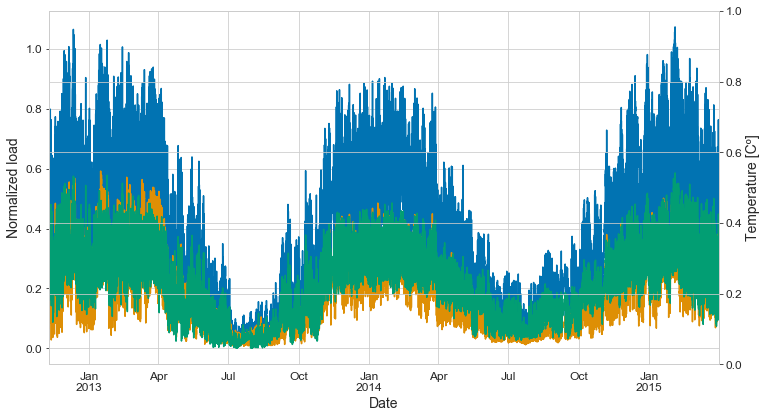

In [117]:
fig, ax = plt.subplots(figsize=figsize)
ax2=ax.twinx()

HP["HP"].plot(ax=ax)
HP["ASHP"]["Ehp"].plot(ax=ax)
HP["GSHP"]["Ehp"].plot(ax=ax)
# df["Temperature"].plot(ax=ax2, color='black')
ax.set_ylabel("Normalized load")
ax2.set_ylabel("Temperature [Cº]")
ax.margins(0, None)
plt.savefig(path_save+"HP_original_norm."+fig_format, bbox_inches='tight', format=fig_format, dpi=1000) 

In [118]:
ASHP.index.name = "index"
ASHP.reset_index(inplace=True)
ASHP = pd.merge(ASHP, temperature, left_on="Date", right_on='Date', how="left")
ASHP['Hhp'] = normalize_serie(ASHP['Hhp'])
ASHP['Ehp'] = normalize_serie(ASHP['Ehp'])
ASHP.set_index("index", drop=True, inplace=True)
ASHP.head()

,Ehp,Edhw,Esp,Eboost,Hhp,COP,Hour,DayOfWeek_name,DayOfWeek,Day,...,Year,Month name,Weekday,HH,Date,Week,Season,Season num,Temperature,Temperature cat
index,,,,,,,,,,,,,,,,,,,,,
2013-10-01 00:00:00,0.102906,0.033546,0.000067,0.0,0.121857,2.310762,0,Tuesday,1,274,...,2013,October,1,0,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 00:30:00,0.098535,0.002614,0.000069,0.0,0.096234,2.323567,0,Tuesday,1,274,...,2013,October,1,1,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 01:00:00,0.109932,0.006842,0.001797,0.0,0.135870,2.281053,1,Tuesday,1,274,...,2013,October,1,2,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 01:30:00,0.092073,0.035351,0.000105,0.0,0.096298,2.327074,1,Tuesday,1,274,...,2013,October,1,3,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 02:00:00,0.107273,0.072567,0.000033,0.0,0.229136,2.323902,2,Tuesday,1,274,...,2013,October,1,4,2013-10-01,40,Autumn,5,14.3,10-15


In [119]:
GSHP.index.name = "index"
GSHP.reset_index(inplace=True)
GSHP = pd.merge(GSHP, temperature, left_on="Date", right_on='Date', how="left")
GSHP['Hhp'] = normalize_serie(GSHP['Hhp'])
GSHP['Ehp'] = normalize_serie(GSHP['Ehp'])
GSHP.set_index("index", drop=True, inplace=True)
GSHP.head()

,Ehp,Edhw,Esp,Eboost,Hhp,COP,Hour,DayOfWeek_name,DayOfWeek,Day,...,Year,Month name,Weekday,HH,Date,Week,Season,Season num,Temperature,Temperature cat
index,,,,,,,,,,,,,,,,,,,,,
2013-10-01 00:00:00,0.163130,0.0,0.0,0.0,0.123478,2.740457,0,Tuesday,1,274,...,2013,October,1,0,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 00:30:00,0.138865,0.0,0.0,0.0,0.051201,2.648673,0,Tuesday,1,274,...,2013,October,1,1,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 01:00:00,0.178546,0.0,0.0,0.0,0.117488,2.688885,1,Tuesday,1,274,...,2013,October,1,2,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 01:30:00,0.133348,0.0,0.0,0.0,0.083438,2.723493,1,Tuesday,1,274,...,2013,October,1,3,2013-10-01,40,Autumn,5,14.3,10-15
2013-10-01 02:00:00,0.194114,0.0,0.0,0.0,0.185322,2.780354,2,Tuesday,1,274,...,2013,October,1,4,2013-10-01,40,Autumn,5,14.3,10-15


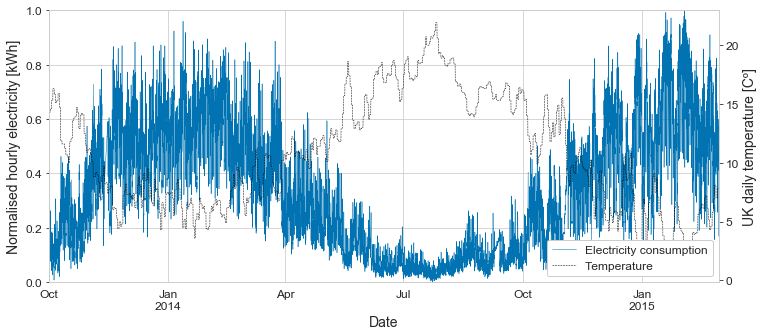

In [120]:
fig, ax = plt.subplots(figsize=(12, 5))
ax2=ax.twinx()
ASHP["Ehp"].plot(ax=ax, linewidth=0.5, label="Electricity consumption")

ASHP["Temperature"].plot(ax=ax2,color='black', linestyle='--', linewidth=0.5, label="Temperature")

ax.margins(0,0)
ax2.set_ylabel("UK daily temperature [Cº]")
ax.set_ylabel("Normalised hourly electricity [kWh]")
ax.set_xlabel("Date")
ax2.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lgd = ax2.legend(lines+lines2, labels+labels2, facecolor = 'white', framealpha=1, frameon=True, loc=4)


In [121]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def fit_regression_HP(df, x_name, y_name):

    huber = HuberRegressor()
    X= df["Temperature"].values.reshape(-1, 1)
    y = df["COP"].values.ravel()

    m = make_pipeline(PolynomialFeatures(3), huber)

    m.fit(X, y)

    # equation showing the relation between the COP and the temperature
    b1 = m.get_params()['huberregressor'].coef_[0]+m.get_params()['huberregressor'].intercept_
    b2 = m.get_params()['huberregressor'].coef_[1]
    b3 = m.get_params()['huberregressor'].coef_[2]
    b4 = m.get_params()['huberregressor'].coef_[3]
    print(b1,"+", b2, "* X + ", b3,"* X^2 + ", b4, "* X^3")

    return m, b1, b2, b3, b4

In [122]:
def display_COP(df):

    fig, ax = plt.subplots(figsize=figsize)
    ax2=ax.twinx()

    sns.regplot(x=df["Temperature"], y=df["COP"], fit_reg=False, ax=ax, label="daily COP")
    sns.regplot(x=df["Temperature"], y=df["Hhp"], fit_reg=False, ax=ax2, marker='x', label="Heat demand")

    ax2.set_ylabel("Normalised Heat demand")
    ax.set_xlabel("UK daily Temperature [Cº]")
    ax2.set_ylim(0, 1)
    ax2.grid(False)

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lgd = ax2.legend(lines+lines2, labels+labels2, facecolor = 'white', framealpha=1, frameon=True, loc=3)
    return fig, ax

In [123]:
def get_training_df(df, sample='1h'):
    training_df = df.resample(sample).agg({'Hour':'mean', 'Ehp':'sum','Hhp':'sum','COP':'mean','Temperature':'mean', 'Year':'mean', 'Day':'mean'})
    # training_ASHP_df.reset_index(drop=True, inplace=True)
    training_df['key'] = training_df['Year']*366+training_df['Day']
    training_df.drop(["Year","Day"], axis=1, inplace=True)
    training_df['Hhp'] = normalize_serie(training_df['Hhp'])
    training_df['Ehp'] = normalize_serie(training_df['Ehp'])
    return training_df

In [124]:
def fit_model(training_df, X_cols, y_cols, kfold_key="key"):
    model = machine_learning_functions.get_models(1, True)['Xgboost']
    folds = machine_learning_functions.get_groupKfolds(training_df, 250, 5, "key")

    scores = cross_val_score(model, training_df[X_cols], training_df[y_cols], cv=folds)
    print(scores)
    print(np.mean(scores))

    model.fit(training_df[X_cols], training_df[y_cols])
    return model

In [125]:
def synthesize_profile(original_df, start, end, X_cols, regr_model, ml_model):
    synthesized_df = pd.DataFrame()
    synthesized_df["Date"] = pd.date_range(start=start, end=end, freq='60min')
    synthesized_df.set_index("Date", inplace=True)
    synthesized_df.index.name = "index"
    synthesized_df = pd.merge(synthesized_df, original_df[['Hour', 'Temperature']], left_index=True, right_index=True, how="left")
    synthesized_df.dropna(inplace=True)
    
    # equation showing the relation between the COP and the temperature
    b1 = regr_model.get_params()['huberregressor'].coef_[0]+regr_model.get_params()['huberregressor'].intercept_
    b2 = regr_model.get_params()['huberregressor'].coef_[1]
    b3 = regr_model.get_params()['huberregressor'].coef_[2]
    b4 = regr_model.get_params()['huberregressor'].coef_[3]
    print(b1,"+", b2, "* X + ", b3,"* X^2 + ", b4, "* X^3")
    
    synthesized_df["COP"] = synthesized_df["Temperature"].apply(lambda x: beta1 + beta2 * x + beta3*x**2 +beta4*x**3 )

    X_cols.extend(['COP'])
    print(X_cols)
    synthesized_df["Ehp"] = ml_model.predict(synthesized_df[X_cols])
    
    synthesized_df["Hhp"] = synthesized_df["Ehp"]*synthesized_df["COP"]
    synthesized_df['Hhp'] = normalize_serie(synthesized_df['Hhp'])
    return synthesized_df

## ASHP model

In [126]:
ASHP_daily = ASHP.groupby('Date').mean()
ASHP_daily['Hhp'] = normalize_serie(ASHP_daily['Hhp'])

In [127]:
model, beta1, beta2, beta3, beta4 = fit_regression_HP(ASHP_daily, "Temperature", "COP")

1.9664666149056138 + 0.14522200557117199 * X +  -0.011290322787255658 * X^2 +  0.00023851661408496856 * X^3


(1, 3)

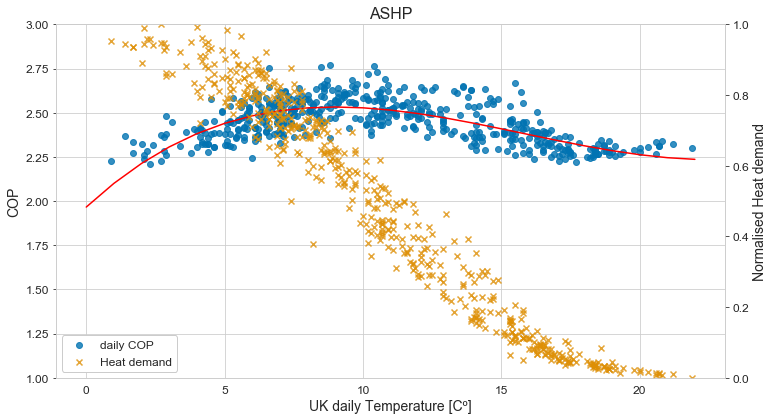

In [128]:
f, ax = display_COP(ASHP_daily)
x = [x for x in range(round(ASHP_daily["Temperature"].min()-1), round(ASHP_daily["Temperature"].max())+1, 1)]
x= np.array(x)
Y_predict= model.predict(x[:, np.newaxis])
ax.set_title("ASHP")
ax.plot(x, Y_predict, color='red', label="Regression model")
ax.set_ylim(1, 3)

In [129]:
training_ASHP_df = get_training_df(ASHP)
print(len(training_ASHP_df["Ehp"].unique()))
training_ASHP_df.to_csv(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Heat data\Training_data_ASHP.csv")
training_ASHP_df.head()

12384


,Hour,Ehp,Hhp,COP,Temperature,key
index,,,,,,
2013-10-01 00:00:00,0,0.098801,0.115033,2.317164,14.3,737032
2013-10-01 01:00:00,1,0.099090,0.122458,2.304064,14.3,737032
2013-10-01 02:00:00,2,0.102737,0.188360,2.293511,14.3,737032
2013-10-01 03:00:00,3,0.166434,0.230959,2.343264,14.3,737032
2013-10-01 04:00:00,4,0.166112,0.221836,2.405057,14.3,737032


In [130]:
X= ["Hour", "Temperature", "COP"]
y = ["Ehp"]
start=pd.to_datetime('20131001-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20150301-0000', format='%Y%m%d-%H%M%', errors='ignore')

xgboost_model = fit_model(training_ASHP_df, X, y)
synthesized_profile = synthesize_profile(training_ASHP_df, start, end, ['Hour', 'Temperature'], model, xgboost_model)

Defined 3 models
[0.93995647 0.93637524 0.93274432 0.93821749 0.94071981]
0.9376026669526893
1.9664666149056138 + 0.14522200557117199 * X +  -0.011290322787255658 * X^2 +  0.00023851661408496856 * X^3
['Hour', 'Temperature', 'COP']


Text(0.5, 0, 'Date')

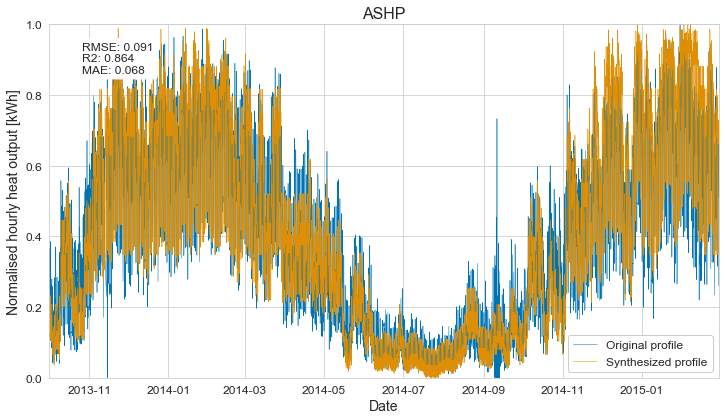

In [131]:
f, ax = plot_synthesize_curve(training_ASHP_df,synthesized_profile, "index", "Hhp")
ax.set_title("ASHP")
ax.set_ylabel("Normalised hourly heat output [kWh]")
ax.set_xlabel("Date")

## GSHP model

In [132]:
GSHP_daily = GSHP.groupby('Date').mean()
GSHP_daily['Hhp'] = normalize_serie(GSHP_daily['Hhp'])

In [133]:
model, beta1, beta2, beta3, beta4 = fit_regression_HP(GSHP_daily, "Temperature", "COP")

2.604175561607966 + 0.0266966400463646 * X +  -0.002595184353053725 * X^2 +  1.9708888566831532e-05 * X^3


(1, 3)

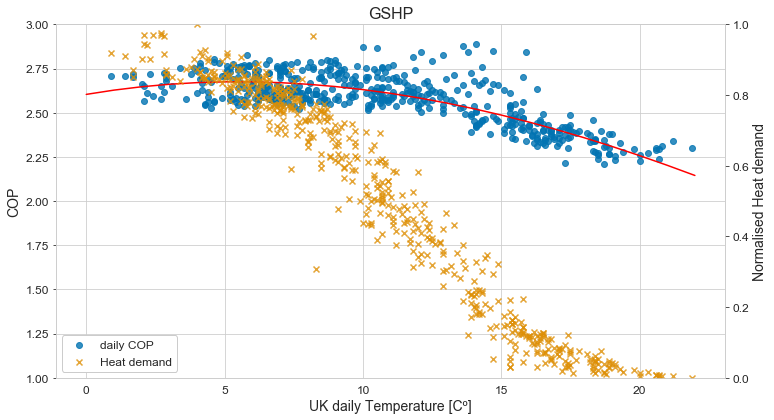

In [134]:
f, ax = display_COP(GSHP_daily)
x = [x for x in range(round(GSHP_daily["Temperature"].min()-1), round(GSHP_daily["Temperature"].max())+1, 1)]
x= np.array(x)
Y_predict= model.predict(x[:, np.newaxis])
ax.set_title("GSHP")
ax.plot(x, Y_predict, color='red', label="Regression model")
ax.set_ylim(1, 3)

In [135]:
training_GSHP_df = get_training_df(GSHP)
print(len(training_GSHP_df["Ehp"].unique()))
training_GSHP_df.to_csv(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Heat data\Training_data_GSHP.csv")
training_GSHP_df.head()

12384


,Hour,Ehp,Hhp,COP,Temperature,key
index,,,,,,
2013-10-01 00:00:00,0,0.147363,0.097713,2.694565,14.3,737032
2013-10-01 01:00:00,1,0.152576,0.112396,2.706189,14.3,737032
2013-10-01 02:00:00,2,0.163930,0.160997,2.803011,14.3,737032
2013-10-01 03:00:00,3,0.138657,0.145681,2.817712,14.3,737032
2013-10-01 04:00:00,4,0.202580,0.225780,2.951353,14.3,737032


In [136]:
X= ["Hour", "Temperature", "COP"]
y = ["Ehp"]
start=pd.to_datetime('20131001-0000', format='%Y%m%d-%H%M%', errors='ignore')
end=pd.to_datetime('20150301-0000', format='%Y%m%d-%H%M%', errors='ignore')
xgboost_model = fit_model(training_GSHP_df, X, y)
synthesized_profile = synthesize_profile(training_GSHP_df, start, end, ['Hour', 'Temperature'], model, xgboost_model)

Defined 3 models
[0.91069438 0.91223335 0.91705389 0.9142638  0.91348249]
0.9135455813572438
2.604175561607966 + 0.0266966400463646 * X +  -0.002595184353053725 * X^2 +  1.9708888566831532e-05 * X^3
['Hour', 'Temperature', 'COP']


Text(0.5, 0, 'Date')

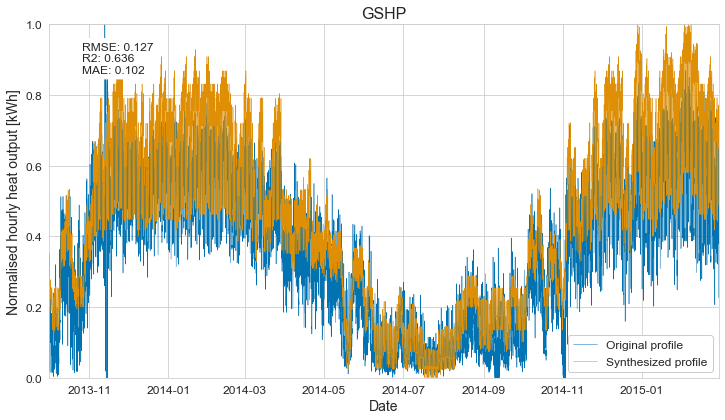

In [137]:
f, ax = plot_synthesize_curve(training_GSHP_df,synthesized_profile, "index", "Hhp")
ax.set_title("GSHP")
ax.set_ylabel("Normalised hourly heat output [kWh]")
ax.set_xlabel("Date")

## Gas boilers / Hydrogen boilers

In [138]:
new_df = pd.read_csv(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Heat data\aggregated_gas_boilers_data.csv", index_col=0, parse_dates=True)
new_df.index.name="index"
addTimePeriod(new_df)
new_df.drop(["Date.1", "ADVANCEDATETIME", "ANON_ID"], axis=1, inplace=True)
dt = datetime.strptime("2009-06-30", '%Y-%m-%d').date()
new_df=new_df[new_df["Date"]>dt]
new_df.reset_index(inplace=True)
new_df.head()

,index,HH,GASKWH,Day,Month,Year,Hour,Minute,DayOfWeek,DayOfYear,Weekday,Week,DayOfWeek_name,Month name,Date,Season,Season num
0,2009-07-01 00:00:00,46,0.052296,182,7,2009,0,0,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4
1,2009-07-01 00:30:00,47,0.052797,182,7,2009,0,30,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4
2,2009-07-01 01:00:00,0,0.053553,182,7,2009,1,0,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4
3,2009-07-01 01:30:00,1,0.052523,182,7,2009,1,30,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4
4,2009-07-01 02:00:00,2,0.054124,182,7,2009,2,0,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4


In [139]:
#get temperature for year 2008 to 2010 from https://open-power-system-data.org/

path_temp = r"D:\Cardiff University\National Grid Project - General\01 - Data\Weather\opsd-weather_data-2019-04-09"
file_temp = "weather_data.csv"

weather_data = pd.read_csv(path_temp+os.path.sep+file_temp, index_col=0, parse_dates=True)
print([x for x in weather_data.columns if "GB" in x])
daily_temp_GB = weather_data.resample('1d').mean()
addTimePeriod(daily_temp_GB)
daily_temp_GB.head()

['GB_temperature', 'GB_radiation_direct_horizontal', 'GB_radiation_diffuse_horizontal']


,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,EE_temperature,EE_radiation_direct_horizontal,EE_radiation_diffuse_horizontal,ES_temperature,ES_radiation_direct_horizontal,ES_radiation_diffuse_horizontal,FI_temperature,...,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,0.780458,3.746733,39.455663,-6.992292,0.939004,9.131862,9.620292,43.476325,42.994000,-7.091125,...,1,1,1980,January,1,0,1980-01-01,1,Winter,1
1980-01-02 00:00:00+00:00,-1.728875,13.012338,43.265342,-4.647958,0.078792,4.424929,7.840500,71.505987,30.671950,-8.353167,...,2,1,1980,January,1,1,1980-01-02,1,Winter,1
1980-01-03 00:00:00+00:00,-0.556333,3.204771,37.957488,-4.594542,0.233275,6.376654,6.777542,78.791996,27.477625,-7.681458,...,3,1,1980,January,1,2,1980-01-03,1,Winter,1
1980-01-04 00:00:00+00:00,-6.095167,5.686375,42.612404,-6.832875,0.741350,8.958488,7.536292,73.597971,30.240912,-10.929583,...,4,1,1980,January,1,3,1980-01-04,1,Winter,1
1980-01-05 00:00:00+00:00,-7.541958,67.969092,25.181267,-7.947583,1.682325,10.485750,7.225708,70.339362,31.800592,-10.954125,...,5,1,1980,January,0,4,1980-01-05,1,Winter,1


In [140]:
cols = ['GB_temperature', 'Date']
new_df = pd.merge(new_df, daily_temp_GB[cols], left_on="Date", right_on="Date", how="left")
new_df.rename(columns = {'GASKWH':'Gas demand'}, inplace = True) 
new_df.set_index("index", inplace=True)
new_df.head()

,HH,Gas demand,Day,Month,Year,Hour,Minute,DayOfWeek,DayOfYear,Weekday,Week,DayOfWeek_name,Month name,Date,Season,Season num,GB_temperature
index,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,46,0.052296,182,7,2009,0,0,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 00:30:00,47,0.052797,182,7,2009,0,30,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 01:00:00,0,0.053553,182,7,2009,1,0,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 01:30:00,1,0.052523,182,7,2009,1,30,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 02:00:00,2,0.054124,182,7,2009,2,0,2,182,1,27,Wednesday,July,2009-07-01,High Summer,4,20.529958


In [141]:
resampled_hourly_df = new_df.resample('1h').agg({'Gas demand':'sum','GB_temperature':'mean'})
resampled_hourly_df['Gas demand'] = normalize_serie(resampled_hourly_df['Gas demand'])
addTimePeriod(resampled_hourly_df)
resampled_hourly_df.reset_index(inplace=True)
resampled_hourly_df.dropna(inplace=True)
resampled_hourly_df.head()

,index,Gas demand,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num
0,2009-07-01 00:00:00,0.001232,20.529958,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4
1,2009-07-01 01:00:00,0.001357,20.529958,1,Wednesday,2,182,7,2009,July,1,1,2009-07-01,27,High Summer,4
2,2009-07-01 02:00:00,0.002102,20.529958,2,Wednesday,2,182,7,2009,July,1,2,2009-07-01,27,High Summer,4
3,2009-07-01 03:00:00,0.005833,20.529958,3,Wednesday,2,182,7,2009,July,1,3,2009-07-01,27,High Summer,4
4,2009-07-01 04:00:00,0.026255,20.529958,4,Wednesday,2,182,7,2009,July,1,4,2009-07-01,27,High Summer,4


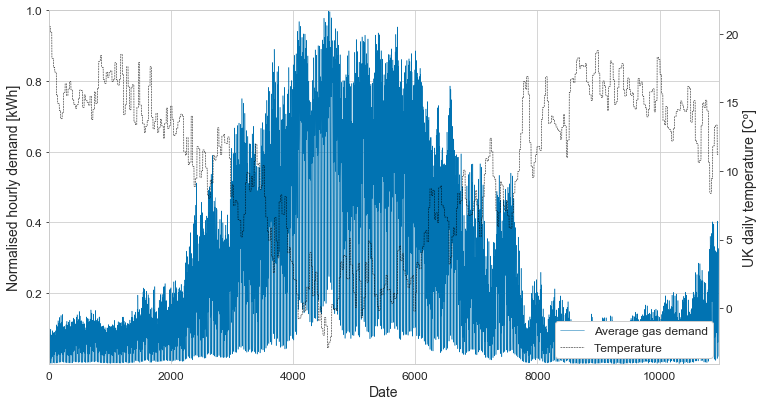

In [142]:
path_save_figures = computer_path + r"OneDrive - Cardiff University\04 - Projects\03 - PhD\02 - Writing\01 - Figures"
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=figsize)

ax2 = ax2=ax.twinx()

resampled_hourly_df.loc[resampled_hourly_df['Gas demand']==0, :]=np.nan

# dt = datetime.strptime("2008-06-30", '%Y-%m-%d').date()
x_values = resampled_hourly_df.loc[:, 'Gas demand'].index.values
y_values = resampled_hourly_df.loc[:, 'Gas demand'].values

ax.plot(x_values, y_values, label="Average gas demand", linewidth=0.5)

x_values = resampled_hourly_df.loc[:, 'GB_temperature'].index.values
y_values = resampled_hourly_df.loc[:, 'GB_temperature'].values

ax2.plot(x_values, y_values, color='black', linestyle='--', linewidth=0.5, label="Temperature")


# y_temp = temperature.loc[temperature["Date"]>dt, "Temperature"].values[:len(y_values)]
# ax2.plot(x_values, y_temp, color='black', linewidth=0.5)

ax.margins(0,0)
ax2.set_ylabel("UK daily temperature [Cº]")
ax.set_ylabel("Normalised hourly demand [kWh]")
ax.set_xlabel("Date")
ax2.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lgd = ax2.legend(lines+lines2, labels+labels2, facecolor = 'white', framealpha=1, frameon=True, loc=4)

# fig.savefig(path_save_figures+os.path.sep+"hourly-profile."+fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)

In [ ]:
## creation of load duration curve from data

In [245]:
district_heating_demand = resampled_hourly_df.groupby(["Day", "Hour"]).mean()["Gas demand"].reset_index(drop=True).copy()

In [220]:
load_duration_curve_df = resampled_hourly_df.groupby(["Day", "Hour"]).mean()["Gas demand"].sort_values(ascending=False).reset_index(drop=True).copy()

## Daily relationship between gas consumption and temperature

In [53]:
resampled_daily_df = new_df.resample('1d').agg({'Gas demand':'sum','GB_temperature':'mean'})
addTimePeriod(resampled_daily_df)
resampled_daily_df.dropna(inplace=True)
resampled_daily_df.head()

,Gas demand,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num
index,,,,,,,,,,,,,,,
2009-07-01,9.185385,20.529958,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4
2009-07-02,9.002963,20.117583,0,Thursday,3,183,7,2009,July,1,1,2009-07-02,27,High Summer,4
2009-07-03,9.261463,18.217250,0,Friday,4,184,7,2009,July,1,2,2009-07-03,27,High Summer,4
2009-07-04,9.747253,17.561125,0,Saturday,5,185,7,2009,July,0,3,2009-07-04,27,High Summer,4
2009-07-05,10.540646,17.207417,0,Sunday,6,186,7,2009,July,0,4,2009-07-05,27,High Summer,4


In [54]:
resampled_daily_df['Gas demand'] = normalize_serie(resampled_daily_df['Gas demand'])
max_temp = round(resampled_daily_df["GB_temperature"].max()+1)

beta1, beta2, beta3 = change_point_model(resampled_daily_df, "GB_temperature",'Gas demand',range(14, max_temp))

beta1, beta2, beta3 = change_point_model(resampled_daily_df, "GB_temperature",'Gas demand', [x/10 for x in range((beta3-1)*10, (beta3+1)*10, 1)])
print(beta1, beta2, beta3)

0.8155187906830541 -0.05606600202904883 14.1


In [55]:
mean = resampled_daily_df.loc[resampled_daily_df["GB_temperature"]>beta3, 'Gas demand'].mean()
print(mean)

0.029185411614230317


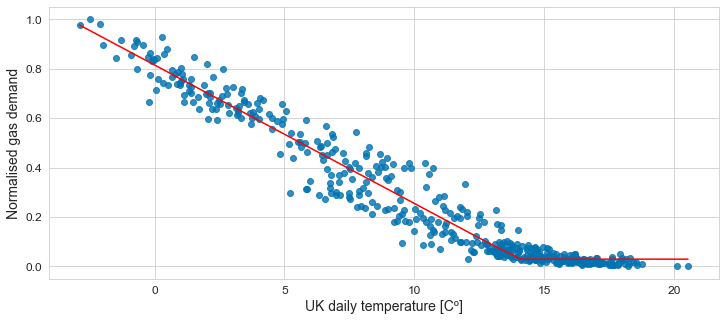

In [56]:
change_point = beta3

fig, ax = plt.subplots(figsize=(12,5))
sns.regplot(x=resampled_daily_df["GB_temperature"], y=resampled_daily_df['Gas demand'], fit_reg=False, ax=ax)

x = list(np.linspace(resampled_daily_df["GB_temperature"].min(),change_point, 15))
x.extend(list(np.linspace(change_point, resampled_daily_df["GB_temperature"].max(), 15)))

Y_predict= [beta2 * x + beta1 if x<change_point else mean for x in x]

ax.set_ylabel("Normalised gas demand")
ax.set_xlabel("UK daily temperature [Cº]")

plt.plot(x, Y_predict, color='red')

plt.show()

## Machine learning model for gas boilers

In [57]:
## Training dataset
resampled_hourly_df.dropna(inplace=True)
resampled_hourly_df = pd.merge(resampled_hourly_df, resampled_daily_df[['Gas demand', "Date"]], left_on="Date", right_on="Date", how="left")
resampled_hourly_df.rename(columns = {'Gas demand_x':'Hourly gas demand', 'Gas demand_y':'Daily gas demand'}, inplace = True) 
resampled_hourly_df.set_index("index", inplace=True)
resampled_hourly_df.head()

,Hourly gas demand,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num,Daily gas demand
index,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,0.001232,20.529958,0.0,Wednesday,2.0,182.0,7.0,2009.0,July,1.0,0.0,2009-07-01,27.0,High Summer,4.0,0.001521
2009-07-01 01:00:00,0.001357,20.529958,1.0,Wednesday,2.0,182.0,7.0,2009.0,July,1.0,1.0,2009-07-01,27.0,High Summer,4.0,0.001521
2009-07-01 02:00:00,0.002102,20.529958,2.0,Wednesday,2.0,182.0,7.0,2009.0,July,1.0,2.0,2009-07-01,27.0,High Summer,4.0,0.001521
2009-07-01 03:00:00,0.005833,20.529958,3.0,Wednesday,2.0,182.0,7.0,2009.0,July,1.0,3.0,2009-07-01,27.0,High Summer,4.0,0.001521
2009-07-01 04:00:00,0.026255,20.529958,4.0,Wednesday,2.0,182.0,7.0,2009.0,July,1.0,4.0,2009-07-01,27.0,High Summer,4.0,0.001521


In [58]:
training_df = resampled_hourly_df[["Hour", "GB_temperature", "Daily gas demand", "Hourly gas demand"]].copy()
training_df.dropna(inplace=True)
len(training_df["Daily gas demand"].unique())
training_df.to_csv(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Heat data\Training_data_boiler.csv")

In [59]:
# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor(max_depth=5)

model = machine_learning_functions.get_models(1, True)['Xgboost']
folds = machine_learning_functions.get_groupKfolds(training_df, 250, 5, "Daily gas demand")

X= ["Hour", "GB_temperature", "Daily gas demand"]
y = ["Hourly gas demand"]
scores = cross_val_score(model, training_df[X], training_df[y], cv=folds)
print(scores)

model.fit(training_df[X], training_df[y])

Defined 3 models
[0.97656667 0.97064366 0.97214441 0.97108675 0.97368024]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [60]:
np.mean([0.97656667, 0.97064366, 0.97214441, 0.97108675, 0.97368024])

0.972824346

In [61]:
## Synthesize profile

In [62]:
start=datetime.strptime("2008-07-01", '%Y-%m-%d').date() #resampled_hourly_df["Date"][0]
end=dt = datetime.strptime("2010-10-01", '%Y-%m-%d').date()

synthesized_df = pd.DataFrame()
synthesized_df["Date"] = pd.date_range(start=start, end=end, freq='60min')
synthesized_df.set_index("Date", inplace=True)

synthesized_df = pd.merge(synthesized_df, resampled_hourly_df["GB_temperature"], left_index=True, right_index=True, how="left")
synthesized_df.dropna(inplace=True)
synthesized_df.head()

,GB_temperature
Date,
2009-07-01 00:00:00,20.529958
2009-07-01 01:00:00,20.529958
2009-07-01 02:00:00,20.529958
2009-07-01 03:00:00,20.529958
2009-07-01 04:00:00,20.529958


In [63]:
#Change point model parameters
beta1=0.8155187906830541
beta2=-0.05606600202904883
change_point=14.1
mean = 0.029185411614230317

synthesized_df["Daily gas demand"] = synthesized_df["GB_temperature"].apply(lambda x: beta2 * x + beta1 if x<change_point else mean)
# synthesized_df.set_index("index", inplace=True)
addTimePeriod(synthesized_df)

In [64]:
synthesized_df["Hourly gas demand"] = model.predict(synthesized_df[X])

In [65]:
synthesized_df

,GB_temperature,Daily gas demand,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num,Hourly gas demand
Date,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,20.529958,0.029185,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4,0.004271
2009-07-01 01:00:00,20.529958,0.029185,1,Wednesday,2,182,7,2009,July,1,1,2009-07-01,27,High Summer,4,0.004271
2009-07-01 02:00:00,20.529958,0.029185,2,Wednesday,2,182,7,2009,July,1,2,2009-07-01,27,High Summer,4,0.004271
2009-07-01 03:00:00,20.529958,0.029185,3,Wednesday,2,182,7,2009,July,1,3,2009-07-01,27,High Summer,4,0.006234
2009-07-01 04:00:00,20.529958,0.029185,4,Wednesday,2,182,7,2009,July,1,4,2009-07-01,27,High Summer,4,0.041016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-09-30 19:00:00,11.206750,0.187201,19,Thursday,3,273,9,2010,September,1,18,2010-09-30,39,Autumn,5,0.243709
2010-09-30 20:00:00,11.206750,0.187201,20,Thursday,3,273,9,2010,September,1,19,2010-09-30,39,Autumn,5,0.199230
2010-09-30 21:00:00,11.206750,0.187201,21,Thursday,3,273,9,2010,September,1,20,2010-09-30,39,Autumn,5,0.152392


Text(0.5, 0, 'Date')

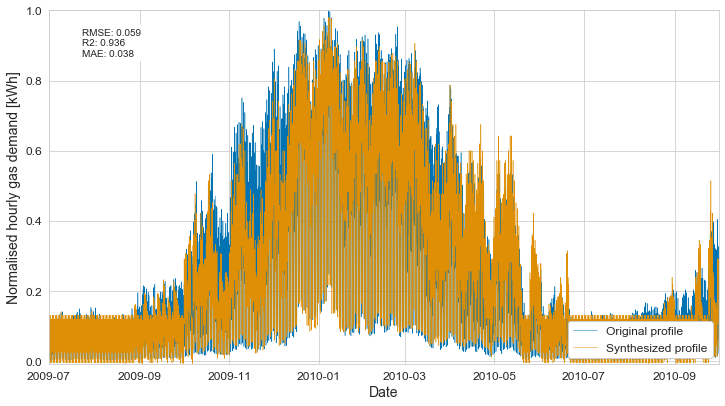

In [66]:
f, ax = plot_synthesize_curve(resampled_hourly_df,synthesized_df, "index", "Hourly gas demand")
ax.set_ylabel("Normalised hourly gas demand [kWh]")
ax.set_xlabel("Date")

## Resistance heaters

In [289]:
new_df = pd.read_csv(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Heat data\aggregated_electricity_for_heat.csv", index_col=0, parse_dates=True)
new_df.index.name="index"

new_df.drop(["Date.1"], axis=1, inplace=True)

addTimePeriod(new_df)
new_df.reset_index(inplace=True)
new_df.head()

,index,HH,ELECKWH_x,Day,Month,Year,Hour,Minute,DayOfWeek,DayOfYear,Weekday,Week,ELECKWH_y,Elec for heat,DayOfWeek_name,Month name,Date,Season,Season num
0,2009-07-01 00:00:00,0,0.135560,182,7,2009,0,0,2,182,1,27,0.112833,0.022728,Wednesday,July,2009-07-01,High Summer,4
1,2009-07-01 00:30:00,1,0.143106,182,7,2009,0,30,2,182,1,27,0.105187,0.037919,Wednesday,July,2009-07-01,High Summer,4
2,2009-07-01 01:00:00,2,0.140571,182,7,2009,1,0,2,182,1,27,0.102341,0.038230,Wednesday,July,2009-07-01,High Summer,4
3,2009-07-01 01:30:00,3,0.134034,182,7,2009,1,30,2,182,1,27,0.100266,0.033768,Wednesday,July,2009-07-01,High Summer,4
4,2009-07-01 02:00:00,4,0.130990,182,7,2009,2,0,2,182,1,27,0.099865,0.031125,Wednesday,July,2009-07-01,High Summer,4


In [290]:
cols = ['GB_temperature', 'Date']
new_df = pd.merge(new_df, daily_temp_GB[cols], left_on="Date", right_on="Date", how="left")
new_df.rename(columns = {'Elec for heat':'Electricity demand'}, inplace = True) 
new_df.set_index("index", inplace=True)
new_df.head()

,HH,ELECKWH_x,Day,Month,Year,Hour,Minute,DayOfWeek,DayOfYear,Weekday,Week,ELECKWH_y,Electricity demand,DayOfWeek_name,Month name,Date,Season,Season num,GB_temperature
index,,,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,0,0.135560,182,7,2009,0,0,2,182,1,27,0.112833,0.022728,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 00:30:00,1,0.143106,182,7,2009,0,30,2,182,1,27,0.105187,0.037919,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 01:00:00,2,0.140571,182,7,2009,1,0,2,182,1,27,0.102341,0.038230,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 01:30:00,3,0.134034,182,7,2009,1,30,2,182,1,27,0.100266,0.033768,Wednesday,July,2009-07-01,High Summer,4,20.529958
2009-07-01 02:00:00,4,0.130990,182,7,2009,2,0,2,182,1,27,0.099865,0.031125,Wednesday,July,2009-07-01,High Summer,4,20.529958


In [304]:
resampled_hourly_df = new_df.resample('1h').agg({'Electricity demand':'sum', 'ELECKWH_x': 'sum', 'ELECKWH_y': 'sum','GB_temperature':'mean'})
resampled_hourly_df['Electricity demand'] = normalize_serie(resampled_hourly_df['Electricity demand'])
addTimePeriod(resampled_hourly_df)
# resampled_hourly_df.reset_index(inplace=True)
resampled_hourly_df.dropna(inplace=True)
resampled_hourly_df.head()

,Electricity demand,ELECKWH_x,ELECKWH_y,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num
index,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,0.108881,0.278667,0.218019,20.529958,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4
2009-07-01 01:00:00,0.119378,0.274605,0.202607,20.529958,1,Wednesday,2,182,7,2009,July,1,1,2009-07-01,27,High Summer,4
2009-07-01 02:00:00,0.113216,0.263818,0.198483,20.529958,2,Wednesday,2,182,7,2009,July,1,2,2009-07-01,27,High Summer,4
2009-07-01 03:00:00,0.110008,0.258852,0.196987,20.529958,3,Wednesday,2,182,7,2009,July,1,3,2009-07-01,27,High Summer,4
2009-07-01 04:00:00,0.120839,0.278554,0.204976,20.529958,4,Wednesday,2,182,7,2009,July,1,4,2009-07-01,27,High Summer,4


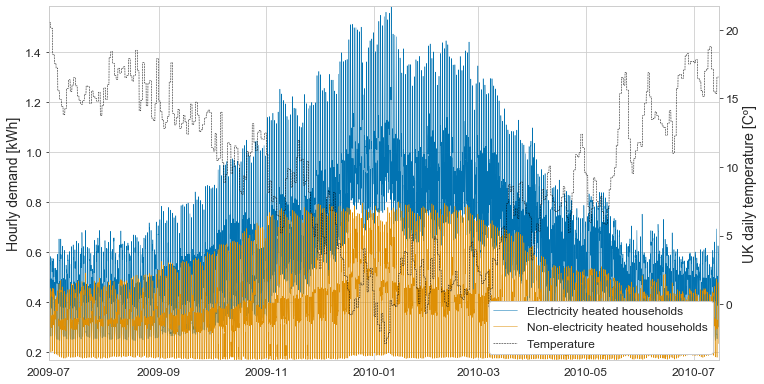

In [300]:
path_save_figures = computer_path + r"OneDrive - Cardiff University\04 - Projects\03 - PhD\02 - Writing\01 - Figures"
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=figsize)

ax2 = ax2=ax.twinx()

resampled_hourly_df.loc[resampled_hourly_df['ELECKWH_x']==0, :]=np.nan

# dt = datetime.strptime("2008-06-30", '%Y-%m-%d').date()
x_values = resampled_hourly_df.loc[:, 'ELECKWH_x'].index.values
y_values = resampled_hourly_df.loc[:, 'ELECKWH_x'].values

ax.plot(x_values, y_values, linewidth=0.5, label="Electricity heated households")

resampled_hourly_df.loc[resampled_hourly_df['Electricity demand']==0, :]=np.nan

# dt = datetime.strptime("2008-06-30", '%Y-%m-%d').date()
x_values = resampled_hourly_df.loc[:, 'ELECKWH_y'].index.values
y_values = resampled_hourly_df.loc[:, 'ELECKWH_y'].values

ax.plot(x_values, y_values, linewidth=0.5, label="Non-electricity heated households")


x_values = resampled_hourly_df.loc[:, 'GB_temperature'].index.values
y_values = resampled_hourly_df.loc[:, 'GB_temperature'].values

ax2.plot(x_values, y_values, color='black', linestyle='--', linewidth=0.5, label="Temperature")


# y_temp = temperature.loc[temperature["Date"]>dt, "Temperature"].values[:len(y_values)]
# ax2.plot(x_values, y_temp, color='black', linewidth=0.5)

ax.margins(0,0)
ax2.set_ylabel("UK daily temperature [Cº]")
ax.set_ylabel("Hourly demand [kWh]")
ax.set_xlabel("")
ax2.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lgd = ax2.legend(lines+lines2, labels+labels2, facecolor = 'white', framealpha=1, frameon=True, loc=4)

# fig.savefig(path_save_figures+os.path.sep+"hourly-profile."+fig_format, bbox_inches='tight', format=fig_format, dpi=dpi)

### Daily relationship between electricity consumption and temperature

In [293]:
resampled_daily_df = new_df.resample('1d').agg({'Electricity demand':'sum','GB_temperature':'mean'})
addTimePeriod(resampled_daily_df)
resampled_daily_df.dropna(inplace=True)
resampled_daily_df.head()

,Electricity demand,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num
index,,,,,,,,,,,,,,,
2009-07-01,2.325755,20.529958,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4
2009-07-02,2.197865,20.117583,0,Thursday,3,183,7,2009,July,1,1,2009-07-02,27,High Summer,4
2009-07-03,2.420452,18.217250,0,Friday,4,184,7,2009,July,1,2,2009-07-03,27,High Summer,4
2009-07-04,2.328338,17.561125,0,Saturday,5,185,7,2009,July,0,3,2009-07-04,27,High Summer,4
2009-07-05,2.442663,17.207417,0,Sunday,6,186,7,2009,July,0,4,2009-07-05,27,High Summer,4


In [294]:
resampled_daily_df['Electricity demand'] = normalize_serie(resampled_daily_df['Electricity demand'])
max_temp = round(resampled_daily_df["GB_temperature"].max()+1)

beta1, beta2, beta3 = change_point_model(resampled_daily_df, "GB_temperature",'Electricity demand',range(14, max_temp))

beta1, beta2, beta3 = change_point_model(resampled_daily_df, "GB_temperature",'Electricity demand', [x/10 for x in range((beta3-1)*10, (beta3+1)*10, 1)])
print(beta1, beta2, beta3)

0.8538255946543138 -0.05813825993594817 13.7


In [295]:
mean = resampled_daily_df.loc[resampled_daily_df["GB_temperature"]>beta3, 'Electricity demand'].mean()
print(mean)

0.055698669026077244


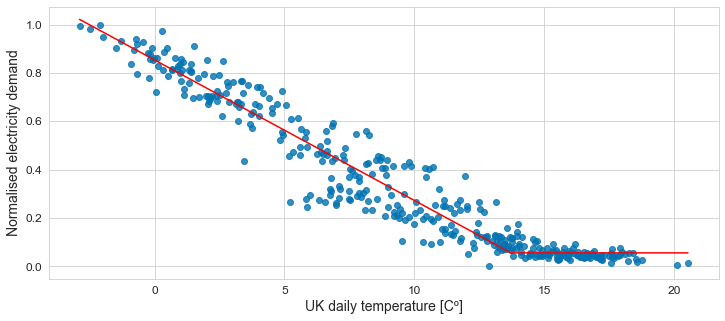

In [296]:
change_point = beta3

fig, ax = plt.subplots(figsize=(12,5))
sns.regplot(x=resampled_daily_df["GB_temperature"], y=resampled_daily_df['Electricity demand'], fit_reg=False, ax=ax)

x = list(np.linspace(resampled_daily_df["GB_temperature"].min(),change_point, 15))
x.extend(list(np.linspace(change_point, resampled_daily_df["GB_temperature"].max(), 15)))

Y_predict= [beta2 * x + beta1 if x<change_point else mean for x in x]

ax.set_ylabel("Normalised electricity demand")
ax.set_xlabel("UK daily temperature [Cº]")

plt.plot(x, Y_predict, color='red')

plt.show()

### Machine learning model for resistance heaters

,Electricity demand,ELECKWH_x,ELECKWH_y,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num
index,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,0.108881,0.278667,0.218019,20.529958,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4
2009-07-01 01:00:00,0.119378,0.274605,0.202607,20.529958,1,Wednesday,2,182,7,2009,July,1,1,2009-07-01,27,High Summer,4
2009-07-01 02:00:00,0.113216,0.263818,0.198483,20.529958,2,Wednesday,2,182,7,2009,July,1,2,2009-07-01,27,High Summer,4
2009-07-01 03:00:00,0.110008,0.258852,0.196987,20.529958,3,Wednesday,2,182,7,2009,July,1,3,2009-07-01,27,High Summer,4
2009-07-01 04:00:00,0.120839,0.278554,0.204976,20.529958,4,Wednesday,2,182,7,2009,July,1,4,2009-07-01,27,High Summer,4


In [307]:
## Training dataset
resampled_hourly_df.dropna(inplace=True)
resampled_hourly_df.reset_index(inplace=True)
resampled_hourly_df = pd.merge(resampled_hourly_df, resampled_daily_df[['Electricity demand', "Date"]], left_on="Date", right_on="Date", how="left")
resampled_hourly_df.rename(columns = {'Electricity demand_x':'Hourly electricity demand', 'Electricity demand_y':'Daily electricity demand'}, inplace = True) 
resampled_hourly_df.set_index("index", inplace=True)
resampled_hourly_df.head()

,Hourly electricity demand,ELECKWH_x,ELECKWH_y,GB_temperature,Hour,DayOfWeek_name,DayOfWeek,Day,Month,Year,Month name,Weekday,HH,Date,Week,Season,Season num,Daily electricity demand
index,,,,,,,,,,,,,,,,,,
2009-07-01 00:00:00,0.108881,0.278667,0.218019,20.529958,0,Wednesday,2,182,7,2009,July,1,0,2009-07-01,27,High Summer,4,0.015686
2009-07-01 01:00:00,0.119378,0.274605,0.202607,20.529958,1,Wednesday,2,182,7,2009,July,1,1,2009-07-01,27,High Summer,4,0.015686
2009-07-01 02:00:00,0.113216,0.263818,0.198483,20.529958,2,Wednesday,2,182,7,2009,July,1,2,2009-07-01,27,High Summer,4,0.015686
2009-07-01 03:00:00,0.110008,0.258852,0.196987,20.529958,3,Wednesday,2,182,7,2009,July,1,3,2009-07-01,27,High Summer,4,0.015686
2009-07-01 04:00:00,0.120839,0.278554,0.204976,20.529958,4,Wednesday,2,182,7,2009,July,1,4,2009-07-01,27,High Summer,4,0.015686


In [308]:
training_df = resampled_hourly_df[["Hour", "GB_temperature", "Daily electricity demand", "Hourly electricity demand"]].copy()
training_df.dropna(inplace=True)
len(training_df["Daily electricity demand"].unique())
training_df.to_csv(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\Heat data\Training_data_resistance_heaters.csv")

In [309]:
# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor(max_depth=5)

model = machine_learning_functions.get_models(1, True)['Xgboost']
folds = machine_learning_functions.get_groupKfolds(training_df, 250, 5, "Daily electricity demand")

X= ["Hour", "GB_temperature", "Daily electricity demand"]
y = ["Hourly electricity demand"]
scores = cross_val_score(model, training_df[X], training_df[y], cv=folds)
print(scores)

model.fit(training_df[X], training_df[y])

Defined 3 models
[0.96095531 0.96484101 0.96326616 0.96259889 0.96014335]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [311]:
np.mean([0.96095531, 0.96484101, 0.96326616, 0.96259889, 0.96014335])

0.9623609439999999

In [87]:
## Synthesize profile

In [312]:
start=datetime.strptime("2008-07-01", '%Y-%m-%d').date() #resampled_hourly_df["Date"][0]
end=dt = datetime.strptime("2010-10-01", '%Y-%m-%d').date()

synthesized_df = pd.DataFrame()
synthesized_df["Date"] = pd.date_range(start=start, end=end, freq='60min')
synthesized_df.set_index("Date", inplace=True)

synthesized_df = pd.merge(synthesized_df, resampled_hourly_df["GB_temperature"], left_index=True, right_index=True, how="left")
synthesized_df.dropna(inplace=True)
synthesized_df.head()

,GB_temperature
Date,
2009-07-01 00:00:00,20.529958
2009-07-01 01:00:00,20.529958
2009-07-01 02:00:00,20.529958
2009-07-01 03:00:00,20.529958
2009-07-01 04:00:00,20.529958


In [313]:
synthesized_df["Daily electricity demand"] = synthesized_df["GB_temperature"].apply(lambda x: beta2 * x + beta1 if x<change_point else mean)
# synthesized_df.set_index("index", inplace=True)
addTimePeriod(synthesized_df)

In [314]:
synthesized_df["Hourly electricity demand"] = model.predict(synthesized_df[X])

Text(0.5, 0, 'Date')

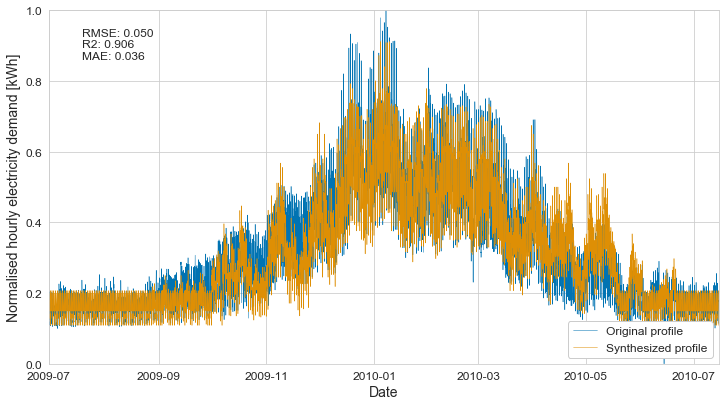

In [315]:
f, ax = plot_synthesize_curve(resampled_hourly_df,synthesized_df, "index", "Hourly electricity demand")
ax.set_ylabel("Normalised hourly electricity demand [kWh]")
ax.set_xlabel("Date")

## District heating

In [221]:
load_duration_curve_df = load_duration_curve_df*5

In [222]:
cap_t1 = 5-load_duration_curve_df.iloc[500]
cap_t2 = 5-cap_t1-load_duration_curve_df.iloc[3500]
cap_t3 = 5-cap_t1-cap_t2-load_duration_curve_df.iloc[8758]
print(cap_t1, cap_t2)

1.2348916306363988 2.7405634971246426


In [223]:
dict_tech={"T1": {"duration":500, "capacity":cap_t1, "next_tech": "T2"},
          "T2": {"duration":3500, "capacity":cap_t2, "next_tech": "T3"},
          "T3": {"duration":8759, "capacity":cap_t3, "next_tech": None}}

3.765108369363601
250.0 4.3825541846818
1.0245448722389585
2250.0 2.39482662080128
0.0014019985234710042
5379.5 0.5129734353812148


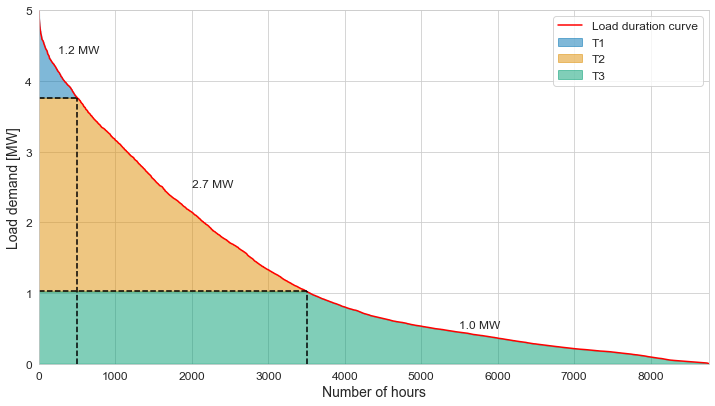

In [253]:
fig, ax = plt.subplots(figsize=figsize)
load_duration_curve_df.plot(ax=ax, color='red', label="Load duration curve")
ax.set_ylabel("Load demand [MW]")
ax.set_xlabel("Number of hours")
ax.margins(0,0)


lower_limit = 5
current_tech = "T1"
temp_df = load_duration_curve_df.copy()
count = 0

while current_tech != None:   
    
    x_value = dict_tech[current_tech]["duration"]
    y_value = dict_tech[current_tech]["capacity"]

    lower_limit =  lower_limit - y_value

    print(lower_limit)
    
    ax.fill_between(temp_df.index[0:x_value].astype('float'), lower_limit, temp_df[0:x_value],
        color=sns.color_palette()[count], alpha=0.5, label = current_tech)

    left_bound = x_value
    temp_df.iloc[0:left_bound] = lower_limit
    next_tech = dict_tech[current_tech]["next_tech"]


    if next_tech != None and lower_limit > 0 :
        plt.plot([0, x_value], [lower_limit, lower_limit], color='black', linestyle='--') 
        plt.plot([x_value, x_value], [0, lower_limit], color='black', linestyle='--') 
    print(x_value/2+count*500, lower_limit+y_value/2)
#     plt.text(x_value/2+count*500, lower_limit+y_value/2, '{:d} MW'.format(int(round(y_value, 0))))
    current_tech = next_tech
    count= count +1
    
plt.text(250, 4.4, '{:0.1f} MW'.format(dict_tech["T1"]["capacity"]))
plt.text(2000, 2.5, '{:0.1f} MW'.format(dict_tech["T2"]["capacity"]))
plt.text(5500, 0.5, '{:0.1f} MW'.format(dict_tech["T3"]["capacity"]))

ax.legend()

In [250]:
district_heating_demand = district_heating_demand*5

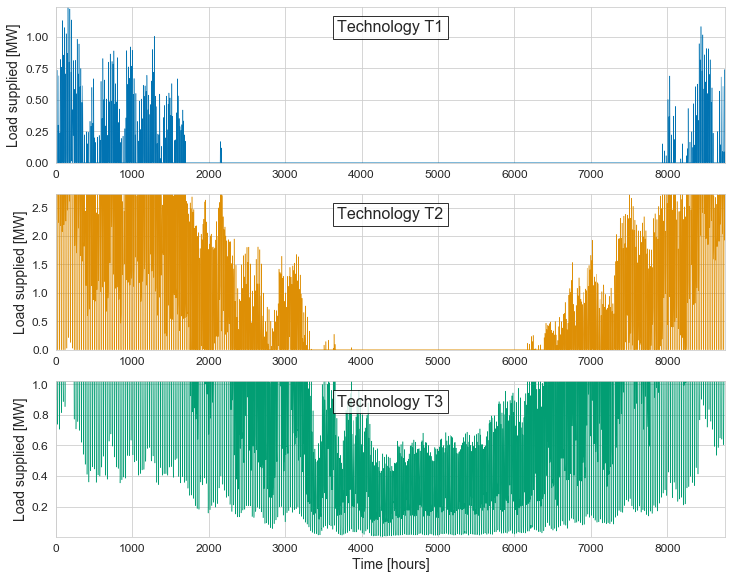

In [284]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1 ,figsize=(figsize[0], figsize[1]*1.5))

heat_supply_t1 = district_heating_demand.copy()
heat_supply_t1 = heat_supply_t1 - cap_t2 - cap_t3
heat_supply_t1[heat_supply_t1<0]=0
heat_supply_t1.plot(ax=ax1, linewidth=0.5, color=sns.color_palette()[0])

ax1.set_title("Technology T1", y=0.8, bbox=dict( facecolor = 'white', edgecolor='black', alpha=0.8))
ax1.set_ylabel("Load supplied [MW]")

heat_supply_t2 = district_heating_demand.copy()
heat_supply_t2 = heat_supply_t2 - heat_supply_t1 - cap_t3
heat_supply_t2[heat_supply_t2<0]=0
heat_supply_t2.plot(ax=ax2, linewidth=0.5, color=sns.color_palette()[1])

ax2.set_title("Technology T2", y=0.8, bbox=dict( facecolor = 'white', edgecolor='black', alpha=0.8))
ax2.set_ylabel("Load supplied [MW]")

heat_supply_t3 = district_heating_demand.copy()
heat_supply_t3 = heat_supply_t3 - heat_supply_t2 - heat_supply_t1
heat_supply_t3[heat_supply_t3<0]=0
heat_supply_t3.plot(ax=ax3, linewidth=0.5, color=sns.color_palette()[2])

ax3.set_title("Technology T3", y=0.8, bbox=dict( facecolor = 'white', edgecolor='black', alpha=0.8))
ax3.set_ylabel("Load supplied [MW]")

ax3.set_xlabel("Time [hours]")
ax1.margins(0,0)
ax2.margins(0,0)
ax3.margins(0,0)